Demonstrate frequency scanning using a simulated resonator.  

* kids.sweep() uses a single tone
* kids.set_tones() and kids.sweep_tones() first sets tones at nominal values, and the sweeps them all, using two tones:  one centered on the resonator and a second tone, off resonance.

In [1]:
import sys
sys.path.append('../../../qick/qick_lib/')
sys.path.append('../soft/')
import Scan
from mkids import *
import matplotlib.pyplot as plt


In [2]:
board = Scan.getBoard()
if board == 'zcu111':
    bitfile = 'mkids_2x2_kidsim_v1'    
elif board == 'zcu216':
    bitfile = 'mkids_2x2_kidsim_v2'
else:
    raise Exception("Do not know what to do with %s"%board)
scan = Scan.Scan(bitfile, iKids=0, iSimu=0)

In [3]:
fMixerSimu = 512
fMixerKids = 700
fResonance = 789.0123
fOffset = 12.3456
fc = 790
df = 10 # Sweep Width
N = 250 # Number of points in a sweep

In [4]:
# Initialize simulation chain with one resonance
simu = scan.simuChain
simu.analysis.qout(3)
simu.synthesis.qout(3)
simu.alloff()

# Set mixer.
simu.set_mixer_frequency(fMixerSimu)

# Put one resonator 
print("fResonance = {} MHz".format(fResonance))
simu.enable(fResonance)

fResonance = 789.0123 MHz


In [5]:
# Get the kids chain
kids = scan.kidsChain
kids.analysis.qout(2)
kids.synthesis.qout(2)


In [6]:
help(kids.sweep)

Help on method sweep in module mkids:

sweep(fstart, fend, N=10, g=0.5, decimation=2, set_mixer=True, verbose=False, showProgress=True, doProgress=False, doPlotFirst=False) method of mkids.KidsChain instance



In [7]:

f,a,phi=kids.sweep(fc-df/2,fc+df/2,N=N,g=0.1, showProgress=False, doProgress=True)

  0%|          | 0/250 [00:00<?, ?it/s]

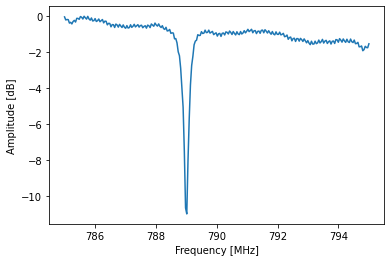

In [8]:
plt.plot(f,20*np.log10(a/max(a)))
plt.xlabel("Frequency [MHz]");
plt.ylabel("Amplitude [dB]");


In [9]:
kids.set_mixer_frequency(fMixerKids)

freqs = np.array([fResonance, fResonance+fOffset])
fis = np.array([0.1, 0.2])
gs = np.array([0.4, 0.6])
kids.set_tones(freqs, fis, gs)
xs = kids.sweep_tones(df, N, mean=True, doProgress=True)



  0%|          | 0/250 [00:00<?, ?it/s]

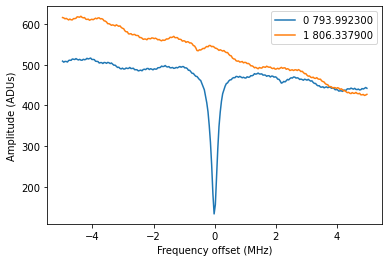

In [10]:
offsets = kids.get_sweep_offsets(df, N)

for iTone,qFreq in enumerate(kids.qFreqs):
    plt.plot(offsets, np.abs(xs[:,iTone]), label="%d %f"%(iTone,qFreq))
plt.xlabel("Frequency offset (MHz)")
plt.ylabel("Amplitude (ADUs)")
plt.legend()


  0%|          | 0/250 [00:00<?, ?it/s]

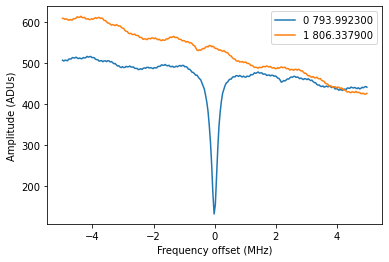

In [11]:
# Repeat the scan
kids.set_tones(freqs, fis, gs)
xs2 = kids.sweep_tones(df, N, mean=True, doProgress=True)
for iTone,qFreq in enumerate(kids.qFreqs):
    plt.plot(offsets, np.abs(xs2[:,iTone]), label="%d %f"%(iTone,qFreq))
plt.xlabel("Frequency offset (MHz)")
plt.ylabel("Amplitude (ADUs)")
plt.legend()


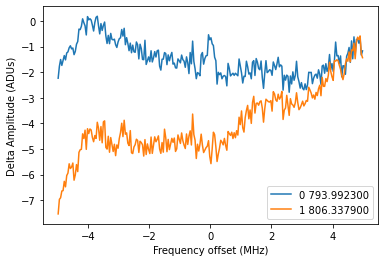

In [12]:
# Plot difference of first and second scan
for iTone,qFreq in enumerate(kids.qFreqs):
    plt.plot(offsets, np.abs(xs2[:,iTone])-np.abs(xs[:,iTone]), label="%d %f"%(iTone,qFreq))
plt.xlabel("Frequency offset (MHz)")
plt.ylabel("Delta Amplitude (ADUs)")
plt.legend()


In [13]:
# Now turn off sumulated resonance and scan again
simu.alloff()
kids.set_tones(freqs, fis, gs)
xs3 = kids.sweep_tones(df, N, mean=True, doProgress=True)


  0%|          | 0/250 [00:00<?, ?it/s]

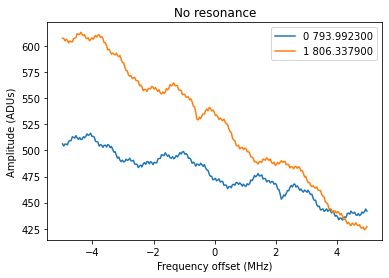

In [14]:
for iTone,qFreq in enumerate(kids.qFreqs):
    plt.plot(offsets, np.abs(xs3[:,iTone]), label="%d %f"%(iTone,qFreq))
plt.xlabel("Frequency offset (MHz)")
plt.ylabel("Amplitude (ADUs)")
plt.legend()
_ = plt.title("No resonance")


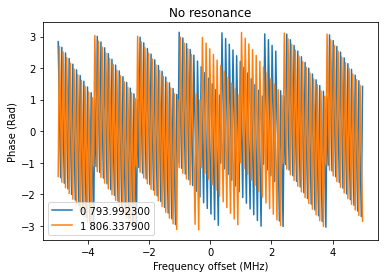

In [15]:
for iTone,qFreq in enumerate(kids.qFreqs):
    plt.plot(offsets, np.angle(xs3[:,iTone]), label="%d %f"%(iTone,qFreq))
plt.xlabel("Frequency offset (MHz)")
plt.ylabel("Phase (Rad)")
plt.legend()
_ = plt.title("No resonance")


In [16]:
delayFreqs = scan.inCh2Freq([9,10])
kids.set_tones(delayFreqs, fis, gs)
delayDf = .3
delayN = 100
delayOffsets = kids.get_sweep_offsets(delayDf, delayN)

xs4 = kids.sweep_tones(delayDf, delayN, mean=True, doProgress=True)


  0%|          | 0/100 [00:00<?, ?it/s]

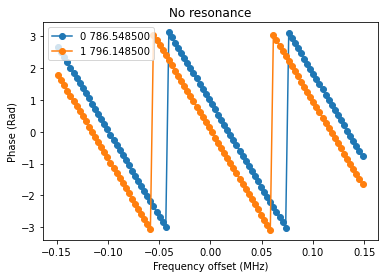

In [17]:
for iTone,qFreq in enumerate(kids.qFreqs):
    plt.plot(delayOffsets, np.angle(xs4[:,iTone]), "-o", label="%d %f"%(iTone,qFreq))
plt.xlabel("Frequency offset (MHz)")
plt.ylabel("Phase (Rad)")
plt.legend()
_ = plt.title("No resonance")


(array([1000.        ,  -20.        ,    1.57079633]), array([[7.66568417e-28, 1.14503878e-37, 9.42979382e-39],
       [1.14503878e-37, 2.33032161e-32, 7.32092125e-35],
       [9.42979382e-39, 7.32092125e-35, 7.66798419e-34]]))
1000 -20 1.5707963267948966


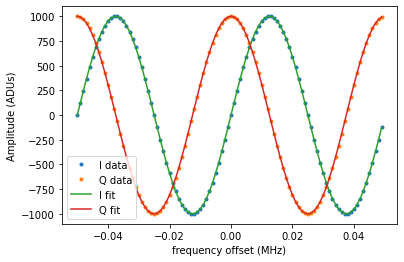

In [20]:
delay = -20
bw = 0.1
n = 100
fOffsets = (np.arange(n)-n/2)*(bw/n)
amp = 1000
phase = np.pi/2
x = amp*np.exp(1j*(2*np.pi*(fOffsets*delay)+phase))
rv = measureDelay(fOffsets, x, plotFit=True)
print(rv)
print(amp, delay, phase)

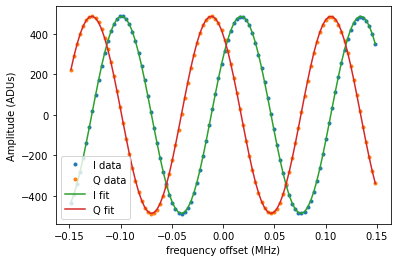

In [21]:
rv = measureDelay(delayOffsets, xs4[:,0], plotFit=True)

In [22]:
print(rv)

(array([487.48890805,  -8.57363756,   0.94869373]), array([[1.98185781e-02, 2.56490176e-12, 3.05646441e-13],
       [2.56490176e-12, 2.81686116e-07, 7.87185410e-17],
       [3.05646441e-13, 7.87185410e-17, 8.33955761e-08]]))


In [23]:
def measureDelayDeleteThis(offsets, xs):
    plt.plot(offsets, np.real(xs), "o", label="I")
    plt.plot(offsets, np.imag(xs), "o", label="Q")
    plt.xlabel("delta frequency (MHz)")
    plt.ylabel("Amplitude (ADUs)")
    plt.legend()
    plt.show()
    f,pxx = welch(xs, fs=1.0/np.diff(offsets).mean(), nperseg=len(xs),  return_onesided=False)
    #plt.plot(f,pxx, '.')
    #plt.show()
    delay0 = f[pxx.argmax()]
    print("delay0 =",delay0)
    amplitude0 = np.abs(xs).mean()
    print("amplitude0 =",amplitude0)
    xsCorr = amplitude0*np.exp(1j*2*np.pi*(offsets*delay0))
    plt.plot(offsets, np.real(xsCorr), 'o', label="corr I")
    plt.plot(offsets, np.imag(xsCorr), 'o', label="corr I")
    plt.legend()
    plt.show()
    corr = correlate(xs,xsCorr)
    lags = correlation_lags(xs.size, xsCorr.size)
    plt.plot(lags,np.real(corr), '.', label="Real")
    plt.plot(lags,np.imag(corr), '.', label="Imag")
    lag = lags[np.argmax(corr)]
    print(" lag =",lag)
    return corr
corr = measureDelay(delayOffsets, xs4[:,0])   
#print(corr)

In [24]:
from scipy import signal
rng = np.random.default_rng()
x = rng.standard_normal(1000)
y = np.concatenate([rng.standard_normal(100), x])
print(x.size,y.size)
correlation = signal.correlate(x, y, mode="full")
lags = signal.correlation_lags(x.size, y.size, mode="full")
lag = lags[np.argmax(correlation)]
print("lag =",lag)

1000 1100
lag = -100


delay = 0.04000000000000001
lag = 19 0.038


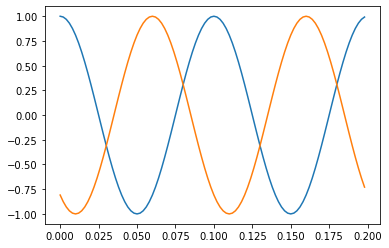

In [25]:
freq = 10 # MHz
fs = 500
ns = 100
a = 1.0
t = np.arange(ns)/fs
y1 = a*np.exp(1j*2*np.pi*t*freq)
delay = 0.4*(1/freq)
print("delay =",delay)
y2 = a*np.exp(1j*2*np.pi*(t+delay)*freq)
correlation = signal.correlate(y1, y2, mode="full")
lags = signal.correlation_lags(y1.size, y2.size, mode="full")
lag = lags[np.argmax(correlation)]
print("lag =",lag, t[lag])
plt.plot(t, np.real(y1))
plt.plot(t, np.real(y2))

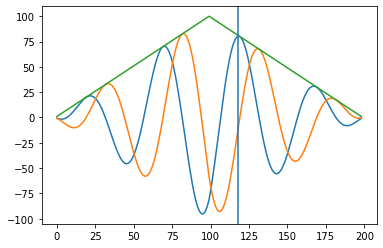

In [26]:
plt.plot(np.real(correlation))
plt.plot(np.imag(correlation))
plt.plot(np.abs(correlation))
plt.axvline(np.argmax(correlation))

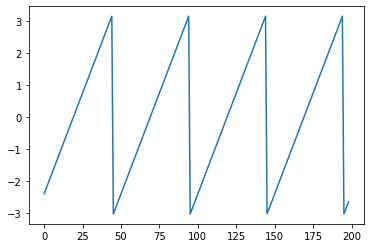

In [27]:
plt.plot(np.angle(correlation))